In [2]:
import pandas as pd
import spacy
import seaborn as sns
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from wordcloud import WordCloud
from wordcloud import STOPWORDS
pd.set_option('display.max_colwidth', None)
from sklearn import set_config
set_config(transform_output='pandas')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/henry/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
def batch_preprocess_texts(
     texts,
     nlp=None,
     remove_stopwords=True,
     remove_punct=True,
     use_lemmas=False,
     disable=["ner"],
     batch_size=50,
     n_process=-1,):
     """Efficiently preprocess a collection of texts using nlp.pipe()

     Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

     Returns:
        list of tokens
     """
     # from tqdm.notebook import tqdm
     from tqdm import tqdm

     if nlp is None:
        nlp = spacy.load("en_core_web_sm")

     processed_texts = []

     for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
     return processed_texts


In [4]:
data = "movie_reviews_v2.csv"
df=pd.read_csv(data)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The businessman is rarely at home, nor is the journalist's wife - which leaves the other two at increasingly loose ends. It isn't long before a friendship develops - usually over some noodles - and though entirely platonic, their relationship becomes solid and trusting. Then, something entirely unexpected occurs that causes the two to refocus their relationship in the face of betrayal and disappointment - and well.... What helps this film stand out are the performances from both Tony Leung (""Chow Mo-wan"") and the gorgeous Maggie Cheung (""Mrs. Chan"") - it's a love story, and it burns intensely - but not physically - as their story subsumes both themselves and the audience. The film looks marvellous, is paced stylishly and uses quite a bit of Nat King Cole to set and keep the mood atmospheric, romantic and interesting. The photography offers us lingering close ups, we get a sense of them falling in love as if we, too, were undergoing the same experience and that all adds to the richness of the story. To give us a breather from the intensity, there are some fun scenes with their very close neighbours who love nothing better than to sit up all night playing mahjong!! Super film, this - flew by.",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a go._",6.0


In [5]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df=df.dropna()
df.isna().sum()

review_id         0
movie_id          0
imdb_id           0
original_title    0
review            0
rating            0
dtype: int64

In [8]:
def group_rating(x):
    if x >=9:
        name = 'high_rating'
    elif x<=4:
        name = 'low_rating'
    else: 
        name = None
    
    return name

In [9]:
group_rating(5.2)

In [10]:
df['group'] = df['rating'].apply(group_rating)
df['group'].value_counts(dropna=False)

group
None           5035
low_rating     1224
high_rating    1195
Name: count, dtype: int64

In [11]:
df = df.dropna(subset='group')
df.isna().sum()

review_id         0
movie_id          0
imdb_id           0
original_title    0
review            0
rating            0
group             0
dtype: int64

In [12]:
import re

regex = r'<[^>]*>'

df['cln_review'] = df['review'].str.replace(regex, " ", regex=True)

In [13]:
df.loc[df['review'].str.contains('<'),['cln_review','review']]

,cln_review,review
174,"Magnificent! A great start to the franchise.\r\n\r\n 'The Lord of the Rings' is yet another film series that I am incredibly late to viewing, at least I've finally got around to it... albeit almost twenty years on from this film's release.\r\n\r\n 'The Lord of the Rings: The Fellowship of the Ring' is delightful. I never know what to expect from a film that goes on for nearly three hours, the pacing has to be near perfection for it to work - and boy does it here. The run time flew by, which is always a terrific sign.\r\n\r\nI love a load of things about this, the one that actually sticks out most is the outstanding score. Music can play a huge part in how much I enjoy a film, so I'm delighted to say that the score is here is fantastic. That is by no means the only positive, obviously.\r\n\r\nThe cast are excellent. Elijah Wood gives a strong performance in the lead role. I've seen Wood in others things down the years and have actually found him a bit hit-and-miss, but here he is very good. Elsewhere, I really enjoyed watching Viggo Mortensen's character.\r\n\r\nAway from those two, there are a whole host of noteworthy cast members. Orlando Bloom, or Will Turner to me, is involved, as are the likes of Ian McKellen and Sean Bean. I also liked Liv Tyler in her role.\r\n\r\nThe look of the film is spectacular, and has aged extremely well even to this day. Everything from the cinematography to the costumes is brilliant, those two things really make the film come alive - helped by the aforementioned score, of course.\r\n\r\nVery eager to check out the sequels, prequels and, eventually, the upcoming television series.","Magnificent! A great start to the franchise.\r\n\r\n<em>'The Lord of the Rings'</em> is yet another film series that I am incredibly late to viewing, at least I've finally got around to it... albeit almost twenty years on from this film's release.\r\n\r\n<em>'The Lord of the Rings: The Fellowship of the Ring'</em> is delightful. I never know what to expect from a film that goes on for nearly three hours, the pacing has to be near perfection for it to work - and boy does it here. The run time flew by, which is always a terrific sign.\r\n\r\nI love a load of things about this, the one that actually sticks out most is the outstanding score. Music can play a huge part in how much I enjoy a film, so I'm delighted to say that the score is here is fantastic. That is by no means the only positive, obviously.\r\n\r\nThe cast are excellent. Elijah Wood gives a strong performance in the lead role. I've seen Wood in others things down the years and have actually found him a bit hit-and-miss, but here he is very good. Elsewhere, I really enjoyed watching Viggo Mortensen's character.\r\n\r\nAway from those two, there are a whole host of noteworthy cast members. Orlando Bloom, or Will Turner to me, is involved, as are the likes of Ian McKellen and Sean Bean. I also liked Liv Tyler in her role.\r\n\r\nThe look of the film is spectacular, and has aged extremely well even to this day. Everything from the cinematography to the costumes is brilliant, those two things really make the film come alive - helped by the aforementioned score, of course.\r\n\r\nVery eager to check out the sequels, prequels and, eventually, the upcoming television series."
212,"Always a pleasure to revisit this. 'Monsters, Inc.' is one of my favourite Disney animated films.\r\n\r\nThe cast and characters are what sets this above the majority of the studio's other work, with so many memorable ones involved. John Goodman (Sully) and Billy Crystal (Mike) make for an outstanding duo in the lead roles, they are truly perfect for their respective roles.\r\n\r\nElsewhere, you have the excellent Steve Buscemi portraying Randall to terrific effect. There are also memorable roles for James Coburn (Waternoose), Jennifer Tilly (Celia) and Bob Peterson (Roz). You, of course, also have Boo (Mary Gibbs) who is simply adorable.\r\n\r\nEverything else from

In [14]:
nlp_no_ner = spacy.load('en_core_web_sm', disable=['parser','ner'])
nlp_no_ner.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [15]:
df['tokens'] = batch_preprocess_texts(df['cln_review'], nlp = nlp_no_ner)
df.head()

2419it [00:24, 96.85it/s] 


,review_id,movie_id,imdb_id,original_title,review,rating,group,cln_review,tokens
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,low_rating,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]"
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,low_rating,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.","[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, ac

In [16]:
df['lemmas'] = batch_preprocess_texts(df['cln_review'], nlp = nlp_no_ner)


2419it [00:25, 94.05it/s] 


In [17]:
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x)).copy()

In [18]:
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,cln_review,tokens,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,low_rating,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low 

In [19]:
high_rating = df[df['group']=='high_rating']
low_rating = df[df['group']=='low_rating']
high_rating.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,cln_review,tokens,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0,high_rating,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, movie, years, ago, forgotten, fresh, like, movies, plot, relies, huge, coincidence, story, gets, sappy, sentimental, places, predictable, religion, suit, thing, suit, f

In [20]:
low_rating.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,cln_review,tokens,lemmas,tokens-joined,lemmas-joined
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,low_rating,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible,underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,low_rating,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion 

In [21]:
high_reviews_tokens = " ".join(high_rating['tokens-joined'])
low_reviews_tokens = " ".join(low_rating['tokens-joined'])

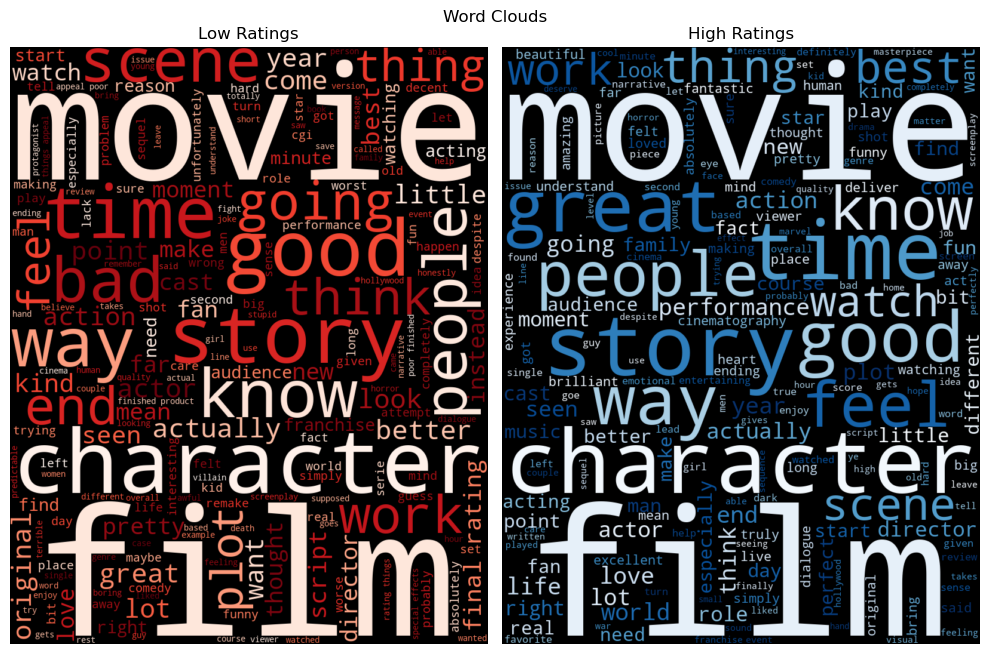

In [22]:
low_cloud = WordCloud(random_state = 42,
                     width = 800,
                     height = 1000,
                     min_word_length = 2, 
                     colormap = 'Reds').generate(low_reviews_tokens)

high_cloud = WordCloud(random_state=42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2,
                      colormap = 'Blues').generate(high_reviews_tokens)

fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds');                                                

In [23]:
custom_stopwords = [*STOPWORDS, 'movie', 'film', 'characters', 'character', 'story', 'people', 'way', 'know', 'time', 'scene', 'thing']

In [24]:
def plot_wordclouds(high_cloud, low_cloud, title='Comparing Word Usage'):
    """Plots the wordlcouds for our two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].imshow(high_cloud)
    axes[0].set_title('High Ratings')
    axes[0].axis('off')
    
    axes[1].imshow(low_cloud)
    axes[1].set_title('Low Ratings')
    axes[1].axis('off')
    fig.tight_layout()
    
    fig.suptitle(title,y=1.0, fontsize='xx-large');
    return fig

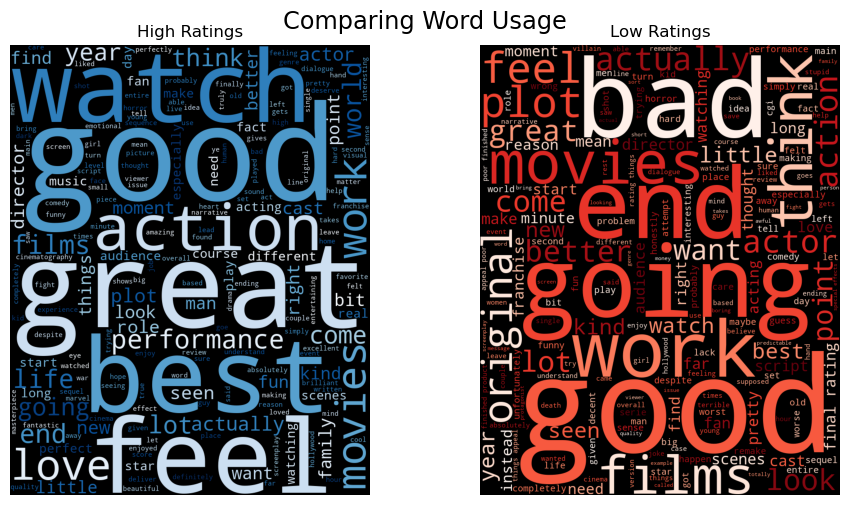

In [25]:
wordcloud_kws = dict(min_word_length = 2, width = 800, height = 1000, random_state = 42,
                    stopwords = custom_stopwords)

high_cloud = WordCloud(**wordcloud_kws, colormap = 'Blues').generate(high_reviews_tokens)
low_cloud = WordCloud(**wordcloud_kws, colormap = 'Reds').generate(low_reviews_tokens)

fig = plot_wordclouds(high_cloud, low_cloud)

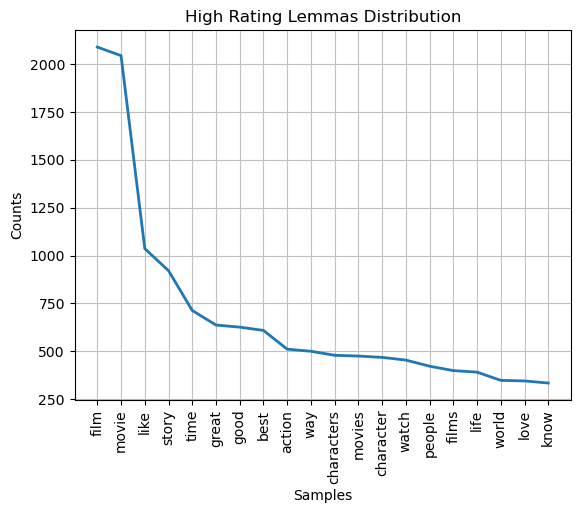

In [26]:
high_words = high_rating['lemmas'].explode().to_list()
low_words = low_rating['lemmas'].explode().to_list()

high_freq_dist = FreqDist(high_words)
low_freq_dist = FreqDist(low_words)

high_freq_dist.plot(20, title = 'High Rating Lemmas Distribution');

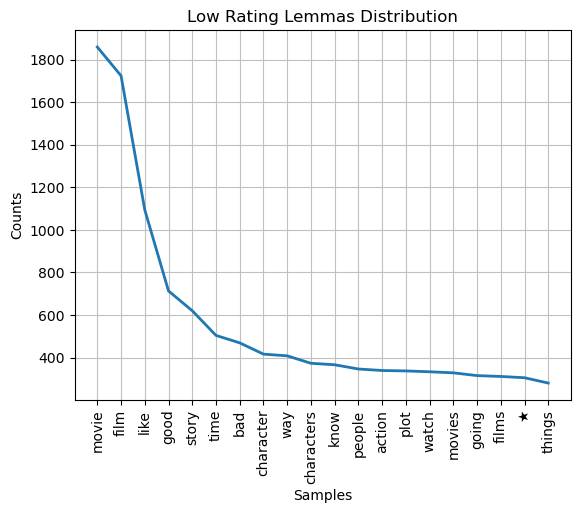

In [27]:
low_freq_dist.plot(20, title = 'Low Rating Lemmas Distribution');

In [28]:
high_words_token_exploded = high_rating['tokens'].explode().to_list()
low_words_token_exploded = low_rating['tokens'].explode().to_list()
high_words_token_exploded[:5]

['guilty', 'pleasure', 'personally', 'love', 'great']

In [29]:
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



In [30]:
top_20_bi_high_words = get_ngram_measures_finder(high_words_token_exploded, ngrams=2, top_n=20).set_index('Words')
top_20_bi_high_words

,Raw Freq
Words,
"(comic, book)",0.000439
"(special, effects)",0.000439
"(star, wars)",0.000403
"(sci, fi)",0.000360
"(feel, like)",0.000352
"(action, movie)",0.000338
"(john, wick)",0.000324
"(watch, movie)",0.000316
"(real, life)",0.000309


In [31]:
top_20_bi_low_words = get_ngram_measures_finder(low_words_token_exploded, ngrams=2, top_n=20).set_index('Words')
top_20_bi_low_words

,Raw Freq
Words,
"(final, rating)",0.001130
"(rating, ★)",0.001130
"(★, ★)",0.001033
"(finished, product)",0.000847
"(appeal, poor)",0.000839
"(poor, finished)",0.000839
"(things, appeal)",0.000839
"(★, things)",0.000839
"(special, effects)",0.000644


In [32]:
top_20_tri_high_words = get_ngram_measures_finder(high_words_token_exploded, ngrams=3, top_n=20).set_index('Words')
top_20_tri_high_words

,Raw Freq
Words,
"(=, =, =)",0.000201
"(spoiler, free, reviews)",0.000173
"(★, ★, ★)",0.000173
"(enjoy, reading, spoiler)",0.000165
"(free, reviews, follow)",0.000165
"(reading, spoiler, free)",0.000165
"(reviews, follow, blog)",0.000165
"(⭐, ⭐, ⭐)",0.000144
"(follow, blog, https://www.msbreviews.com)",0.000122


In [33]:
top_20_tri_low_words = get_ngram_measures_finder(low_words_token_exploded, ngrams=3, top_n=20).set_index('Words')
top_20_tri_low_words

,Raw Freq
Words,
"(final, rating, ★)",0.001130
"(rating, ★, ★)",0.001015
"(appeal, poor, finished)",0.000839
"(poor, finished, product)",0.000839
"(things, appeal, poor)",0.000839
"(★, things, appeal)",0.000839
"(★, ★, things)",0.000839
"(boring, disappointing, avoid)",0.000512
"(disappointing, avoid, possible)",0.000512


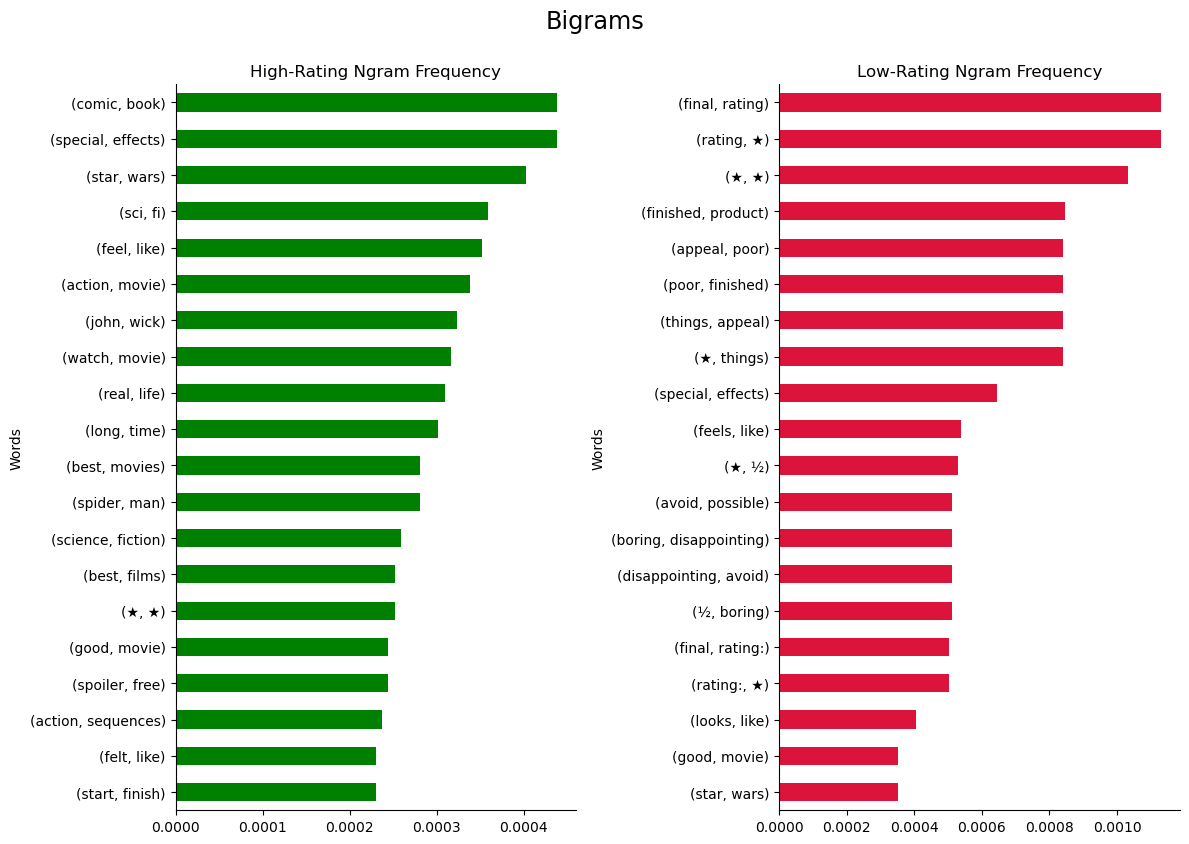

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
## Plot the ngram frequencies
top_20_bi_high_words["Raw Freq"].sort_values().plot(
    kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
)

top_20_bi_low_words["Raw Freq"].sort_values().plot(
    kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
)
# Remove lines from top and right edges (spines)
for ax in axes:
    ax.spines["top"].set_visible(False)  # Remove the top spine
    ax.spines["right"].set_visible(False)  # Remove the right spine

fig.tight_layout()
fig.suptitle("Bigrams", y=1.05, fontsize="xx-large");

/var/folders/yv/f7g5xwx17gsb97dbrw66yt_m0000gn/T/ipykernel_23394/3567760887.py:13: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.tight_layout()
/Users/henry/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  func(*args, **kwargs)
/Users/henry/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


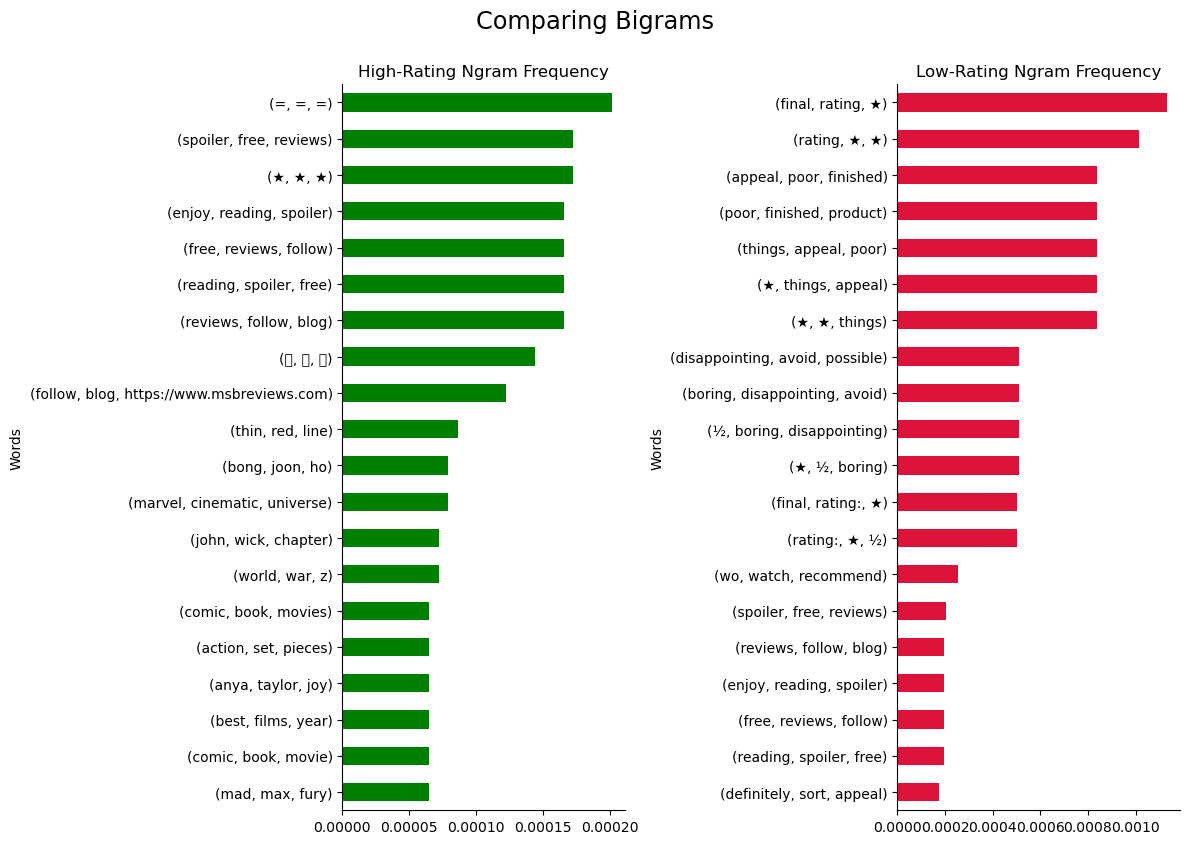

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
top_20_tri_high_words["Raw Freq"].sort_values().plot(
    kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
)

top_20_tri_low_words["Raw Freq"].sort_values().plot(
    kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
)
for ax in axes:
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

fig.tight_layout()
fig.suptitle("Comparing Bigrams", y=1.05, fontsize="xx-large");

In [36]:
sia = SentimentIntensityAnalyzer()

In [37]:
df['sentiment_scores'] = df['cln_review'].map(sia.polarity_scores)

review_scores = df['sentiment_scores'].apply(pd.Series)

df = pd.concat([df,review_scores], axis=1).drop('sentiment_scores', axis=1)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,group,cln_review,tokens,lemmas,tokens-joined,lemmas-joined,neg,neu,pos,compound
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high_rating,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,0.053,0.587,0.360,0.9450
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,low_rating,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]","[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty bia

In [38]:
pos_sentiment_reviews = df['compound']>0
pos_sentiment_reviews.sum()

1632

In [39]:
filter_mismatch_pos = (df['group']=='low_rating') & pos_sentiment_reviews
pos_sent_low = df.loc[filter_mismatch_pos,['cln_review', 'rating', 'compound']]
pos_sent_low.head()

,cln_review,rating,compound
72,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like something that could have been believable in the 80's but not for the 2000s, rape kits and a thorough investigation solves the plot. It's pretty to look at and the cast is excellent but the rest of it is unbelievable.",4.0,0.8695
111,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to two direct-to-video sequels that I'm really not too keen to revisit. **2.0/5**",4.0,0.6523
125,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short clothes, and bouncing around sensually in an atmosphere of mockery and debauchery worthy of a university graduation party? A lot of things. What leaves us no doubt? It is a film made with an openly and openly heterosexual audience in mind. Released in 2000, I don't know if the film would be possible today without being immediately accused of sexism and giving a stereotypical and sexualized image of women.\r\n\r\nLet's start by talking about the good things. One of them, perhaps the best, is the extraordinary soundtrack, which compiles excellent songs into one of the best non-original soundtracks of the decade: “The Right Kind of Wrong” and “Can't Fight the Moonlight” are so good that the entire we know them. The music is so important here that, in a sense, it is more of a music video than a film: the protagonist is an aspiring songwriter who tries to make it in the music market without much success, but who discovers that she sings well and becomes one of the main attractions. of a nightclub.\r\n\r\nThe scenarios are convincing enough for us to believe them, especially if it is known that there really is a bar of this type in New York (in fact, it seems that others in the same franchise have already opened). Even so, there is so much exaggeration at parties that it is, in my eyes, difficult to believe in a certified and legal commercial space. Minimally decent editing, but sometimes lax, and cinematography that relies too heavily on red tones complete, on a less positive note, the more technical aspects of this film.\r\n\r\nIn addition to the good songs, we have the beauty of the cast, with young and slender actresses, who make up for their inexperience with fantastic bodies and good dancing skills: Piper Perabo, Maria Bello, Tyra Banks, Izabella Miko, Bridget Moynahan and Adam Garcia. It's a shame that physical beauty doesn't translate into talent: as the cast wasn't chosen based on the actors' abilities, none of them offer an inspired performance. They are a bunch of complete scoundrels and the film, at this point, is very weak. In the interest of justice, it is imperative to save the renowned John Goodman, the only good actor here, who shows us what it is like to act in a character full of grace and quite comical.\r\n\r\nAll of these, however, are mere stumbling blocks on the long road of a production that could, even so, be frankly good if it told us a good story. It is in the script and the story told that the film falls to the ground like an aspiring model who breaks both heels while parading. When watching the film, I asked myself over and over again where the hell the script was, because all that, that whole trip to the city, to a future in show business, is so absolutely cliché and has already been repeated so much that it is unacceptable. There is no substance. Then, all that sugary roman

In [40]:
filter_mismatch_neg = (df['group']=='high_rating') & ~pos_sentiment_reviews
neg_sent_high = df.loc[filter_mismatch_neg,['cln_review','rating','compound']]
neg_sent_high.head()

,cln_review,rating,compound
22,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",9.0,-0.3391
59,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",10.0,-0.5574
75,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows four people through their addictions until the shattering denouement, but the journey is made more bleak by offering tantalising snatches of hope, the dreams of the protags offered up as some sort of goals for the addicts to cling on to - only for the narrative to stick in its rusty serrated blade to draw the lifeblood from the hapless hopefuls.\r\n\r\nArononfsky brings a multitude of technical skills to the party that emphasise the emotional discord on show. Standard split-screening is married up with rapid cutting, isolated framing, close ups, long tracking and Snorricam, all of which is sound tracked by Clint Mansell's haunting musical composition. All told it's an assault on all the senses and terrifying with it, boosted no end by Aronofsky getting top performances from his cast of actors. Love it or hate it, it's a film that simply can't be ignored, unsparing cinema produced by a most gifted director. 9/10",9.0,-0.7907
117,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on board. But pretty soon after the disaster strange accidents start to befall those who got off the plane, it seems that death is out to get them.\r\n\r\nWith the number of hugely disappointing teens in peril movies that were made post the success of Wes Craven's hugely successful Scream, it's refreshing to find one that was, well, refreshing. Not purporting to be anything other than a wickedly entertaining piece of horror based nonsense, Final Destination is inventive, funny and above all else, shock laden.\r\n\r\nFrom the opening, and terrifying air crash sequence to the clever and gross way that our protagonists shake hands with the grim reaper, this film is gloriously proud of its horror intent. One peak at the surnames of the characters will tell you just how into their horror roots the makers are here, whilst not a homage movie as such, James Wong and his team clearly know what makes a modern horror picture work.\r\n\r\nIf you find yourself complaining about the writing then you clearly are missing the point of Final Destination's existence, either that or you are in fact dead yourself! Four fun but vastly inferior sequels would follow, but really this is the one to watch, as good a 100 minutes of horror fun as you could wish to have. I dare you not to jump out your seat at least once! 9/10",9.0,-0.9920
254,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson, Helen Mirren, Tom Noonan, Benicio Del Toro, Mickey Rourke, Dale Dickey, Vanessa Redgrave and Harry Dean Stanton. Music is by Klaus Badelt and Hans Zimmer, and cinematography by Chris Menges.\r\n\r\nPolice chief Jerry Black (Nicholson) is literally on his last day before retitement. But during his leaving party news filters through that a young girl has been brutally murdered. Talking his chiefs into letting him tag along to the crime sce

### Based on your analyses, what should someone do (or not do) if they want to make a highly-rated movie?

- **High rated movies**
    - Originality is key. Highly rated movies were fresh and realistic enough to be relatable or believable. 
    - Characters were well-developed, with depth and layers that make them likeable and memorable. 
    - The plot is engaging, with a balance of tension, relief, and emotional depth.

- **Low rated movies**
    - Used low level cinematography, sound and pictures.
    - Low rated movies used the same storyline over and over again
    - and characters were so unrealistic or one-dimensional that they detract from the story. 